In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
# list cuda devices
print("Available CUDA devices:")
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

Available CUDA devices:
Device 0: NVIDIA RTX A6000
Device 1: NVIDIA RTX A6000


In [3]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_easy-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_easy-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_easy-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_easy-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)

mnist_img_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/mnist_images_easy-train.npy"
mnist_lbls_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/mnist_labels_easy-train.npy"
mnist_img_train = np.load(mnist_img_train_path, allow_pickle=True)
mnist_lbls_train = np.load(mnist_lbls_train_path, allow_pickle=True)

mnist_img_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/mnist_images_easy-validation.npy"
mnist_lbls_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/mnist_labels_easy-validation.npy"
mnist_img_val = np.load(mnist_img_val_path, allow_pickle=True)
mnist_lbls_val = np.load(mnist_lbls_val_path, allow_pickle=True)


## Pretrain convolution filters on MNIST characters

In [4]:
# Create dataset for MNIST characters
class MNIST_Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx][np.newaxis,:,:]
        label = self.labels[idx]
        return image, label

In [5]:
# Create datasets
mnist_train_ds = MNIST_Dataset(mnist_img_train, mnist_lbls_train)
mnist_val_ds = MNIST_Dataset(mnist_img_val, mnist_lbls_val)


In [6]:
class MNIST_Classifier(nn.Module):
    def __init__(self, device='cuda'):
        super(MNIST_Classifier, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(32)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.model()
        self.to(self.device)
        
    def model(self):
        self.mdl = nn.Sequential(
            self.conv1,
            self.mp1,
            self.bnorm1,
            nn.ReLU(),
            self.conv2,
            self.mp2,
            self.bnorm2,
            nn.ReLU(),
            nn.Flatten(),
            self.fc1,
            self.dropout,
            self.fc2
        )

    def forward(self, x):
        x = self.mdl(x)
        return x

In [9]:
mdl = MNIST_Classifier()

optim = torch.optim.Adam(mdl.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

epoch_num = 100

train_dl = DataLoader(mnist_train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(mnist_val_ds, batch_size=1024, shuffle=True)

for i in range(epoch_num):
    mdl.train()
    for imgs, lbls in train_dl:
        imgs, lbls = imgs.to(mdl.device).float(), lbls.to(mdl.device).long()
        optim.zero_grad()
        preds = mdl(imgs)
        loss = loss_fn(preds, lbls)
        loss.backward()
        optim.step()
    
    mdl.eval()
    with torch.no_grad():
        imgs, lbls = next(iter(val_dl))
        imgs, lbls = imgs.to(mdl.device).float(), lbls.to(mdl.device).long()
        preds = mdl(imgs)
        acc = (preds.argmax(dim=1) == lbls).float().mean() * 100
        print(f"Validation Accuracy: {acc.item():.2f}%")


Validation Accuracy: 98.05%
Validation Accuracy: 98.63%
Validation Accuracy: 97.75%
Validation Accuracy: 98.34%
Validation Accuracy: 98.24%
Validation Accuracy: 98.83%
Validation Accuracy: 98.63%
Validation Accuracy: 98.73%
Validation Accuracy: 97.85%
Validation Accuracy: 98.54%
Validation Accuracy: 98.73%
Validation Accuracy: 99.02%
Validation Accuracy: 99.32%
Validation Accuracy: 98.93%
Validation Accuracy: 98.93%
Validation Accuracy: 99.41%
Validation Accuracy: 98.93%
Validation Accuracy: 98.44%
Validation Accuracy: 98.83%
Validation Accuracy: 99.41%
Validation Accuracy: 98.54%
Validation Accuracy: 98.93%
Validation Accuracy: 98.44%
Validation Accuracy: 99.12%
Validation Accuracy: 98.54%
Validation Accuracy: 98.83%
Validation Accuracy: 98.83%
Validation Accuracy: 98.73%
Validation Accuracy: 99.32%
Validation Accuracy: 98.63%
Validation Accuracy: 98.14%
Validation Accuracy: 98.83%
Validation Accuracy: 98.93%
Validation Accuracy: 98.83%
Validation Accuracy: 99.02%
Validation Accuracy:

In [34]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of purely feedforward models
class MC_FF_Dataset(Dataset):
    def __init__(self, data, labels, stack_size=3, use_sector=False, num_sectors=9):
        """
        Args:
            data (np.ndarray): Array of shape (num_samples, num_frames, height, width)
            labels (np.ndarray): DataFrame with columns ['fg_char_id', 'fg_char_x', 'fg_char_y']
            stack_size (int): Number of frames to stack for input as multichannel image
            use_sector (bool): If True, map (x, y) position to sector id 0-(num_sectors-1)
            num_sectors (int): Number of sectors, e.g., 9 means 0-8 sectors (3x3 grid)
        """
        self.data = data
        self.labels = labels[['fg_char_id', 'fg_char_x', 'fg_char_y']].values
        self.stack_size = stack_size
        self.use_sector = use_sector
        self.num_sectors = num_sectors

    def __len__(self):
        return self.data.shape[0] - self.stack_size + 1

    def __getitem__(self, idx):
        # Stack frames to create a multichannel image
        stacked_frames = self.data[idx:(idx + self.stack_size)].astype(np.float32)
        label = self.labels[idx + self.stack_size - 1].copy()
        
        if self.use_sector:
            # Use image width and height to map (x, y) to a grid_size x grid_size grid,
            # obtaining sector id 0-(num_sectors-1) (e.g., num_sectors=9 -> 3x3 grid)
            height = self.data.shape[-2]
            width = self.data.shape[-1]

            # Derive grid_size for each dimension from num_sectors (assuming num_sectors is a perfect square, e.g., 9, 16)
            grid_size = int(np.sqrt(self.num_sectors))
            if grid_size * grid_size != self.num_sectors:
                raise ValueError(f"num_sectors={self.num_sectors} is not a perfect square, cannot form grid_size x grid_size grid")

            x = label[1].astype(np.float32)
            y = label[2].astype(np.float32)

            # Normalize coordinates to [0, grid_size) then round, using (width-1)/(height-1) to avoid out-of-bounds
            col = int((x / max(width - 1, 1)) * grid_size)
            row = int((y / max(height - 1, 1)) * grid_size)

            # Prevent out-of-bounds due to numerical or boundary issues
            col = np.clip(col, 0, grid_size - 1)
            row = np.clip(row, 0, grid_size - 1)

            # Encode sector id in row-major order: row * grid_size + col, range 0-(num_sectors-1)
            sector = row * grid_size + col

            # New label: [char_id, sector_id]
            label = np.array([label[0].astype(np.int64), sector], dtype=np.int64)
        else:
            # Coordinate mode: [char_id, x, y]
            label = np.array([label[0].astype(np.int64), label[1], label[2]], dtype=np.float32)
        
        return stacked_frames, label


In [11]:
train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=3)
val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=3)

In [12]:
ind=30

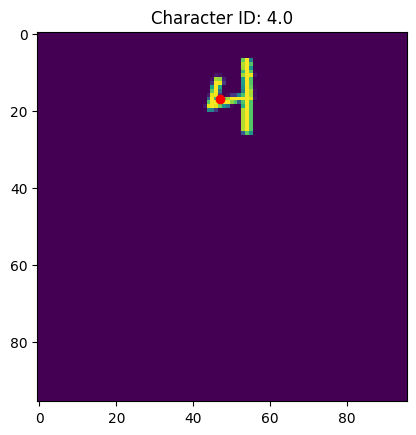

In [7]:
s,l=train_ds[ind]
plt.imshow(s[0, :, :])
plt.scatter(l[1], l[2], c='r')
plt.title(f'Character ID: {l[0]}')
ind+=1

In [13]:
class FeedForwardConv(nn.Module):
    def __init__(self, input_channels, num_classes, num_pos, mnist_pre=None, kernel_size=3, device='cuda'):
        super(FeedForwardConv, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=kernel_size, padding='same')
        if mnist_pre is not None:
            # set weights of self.conv1 to mnist_pre.conv1
            self.conv1.weight.data = torch.cat([torch.zeros(mnist_pre.conv1.weight.shape).to(self.device), 
                                                  torch.zeros(mnist_pre.conv1.weight.shape).to(self.device),
                                                  mnist_pre.conv1.weight], dim=1)
            self.conv1.bias.data = mnist_pre.conv1.bias.data
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        if mnist_pre is not None:
            # set weights of self.conv2 to mnist_pre.conv2
            self.conv2.weight.data = mnist_pre.conv2.weight
            self.conv2.bias.data = mnist_pre.conv2.bias.data
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.fc1 = nn.Linear(64 * 12 * 12, 512)
        self.dropout = nn.Dropout(0.5)
        self.fcchar = nn.Linear(512, num_classes)
        self.fcpos = nn.Linear(512, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.LNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.LNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        return nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.dropout
        )(x)

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)
        x = self.encoder(x)

        x = x.view(x.size(0), -1)
        x = self.middle(x)

        char_out, pos_out = self.classifier(x)
        return char_out, pos_out

In [35]:
# 可视化函数（适配 FeedForward 模型）
def visualize_results_ff(results, model, test_ds, test_dl, use_sector=False, num_sectors=9, num_vis=8, show_test_results=True):
    """
    可视化 FeedForward 模型的训练结果和测试集预测
    
    Args:
        results: 训练结果字典，包含 'train_acc_char', 'val_acc_char' 等（不包含 'model'）
        model: 训练好的模型对象（单独传递）
        test_ds: 测试数据集
        test_dl: 测试数据加载器
        use_sector: 如果为 True，则可视化 sector location；否则可视化坐标
        num_sectors: sector 数量（仅在 use_sector=True 时使用）
        num_vis: 可视化的样本数量
        show_test_results: 如果为 True，则显示测试集的可视化和打印结果；否则跳过
    """
    # 1. 绘制训练 / 验证性能曲线
    # 自动检测实际训练的epoch数（支持早停机制）
    if "actual_epochs" in results:
        actual_epochs = results["actual_epochs"]
    else:
        # 兼容旧版本：使用数组的实际长度（去除末尾的0值）
        train_acc = results["train_acc_char"]
        non_zero_mask = train_acc > 1.0
        if np.any(non_zero_mask):
            actual_epochs = np.where(non_zero_mask)[0][-1] + 1
        else:
            actual_epochs = len(train_acc)
    
    print(f"实际训练的epoch数: {actual_epochs}")
    
    plt.figure(figsize=(12, 5))
    
    # 字符识别准确率（只显示实际训练的epoch）
    plt.subplot(1, 2, 1)
    plt.plot(results["train_acc_char"][:actual_epochs], label="train char acc")
    plt.plot(results["val_acc_char"][:actual_epochs], label="val char acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Character accuracy")
    plt.ylim(0, 100)  # 固定纵坐标范围为0-100
    plt.legend()
    
    # 位置相关指标（只显示实际训练的epoch）
    plt.subplot(1, 2, 2)
    if use_sector:
        # sector 模式：显示准确率
        if "train_acc_pos" in results and "val_acc_pos" in results:
            plt.plot(results["train_acc_pos"][:actual_epochs], label="train sector acc")
            plt.plot(results["val_acc_pos"][:actual_epochs], label="val sector acc")
            plt.ylabel("Accuracy (%)")
            plt.title("Sector accuracy")
            plt.ylim(0, 100)  # 固定纵坐标范围为0-100
        else:
            print("Warning: train_acc_pos or val_acc_pos not found in results")
    else:
        # 坐标模式：显示 MSE
        if "train_err_pos" in results and "val_err_pos" in results:
            plt.plot(results["train_err_pos"][:actual_epochs], label="train pos MSE")
            plt.plot(results["val_err_pos"][:actual_epochs], label="val pos MSE")
            plt.ylabel("MSE (pixel^2)")
            plt.title("Position error")
        else:
            print("Warning: train_err_pos or val_err_pos not found in results")
    plt.xlabel("Epoch")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 2. 使用训练好的模型在 test set 上推理（可选）
    if not show_test_results:
        return
    
    mdl_eval = model
    # 检测设备：如果 CUDA 可用，使用 CUDA；否则使用 CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mdl_eval = mdl_eval.to(device)
    mdl_eval.device = device.type  # 设置模型内部的 device 属性
    mdl_eval.eval()
    
    all_char_pred = []
    all_char_gt = []
    all_pos_pred = []
    all_pos_gt = []
    
    with torch.no_grad():
        for batch in test_dl:
            inputs, labels = batch
            # 确保输入数据在正确的设备上
            inputs = inputs.to(device)
            labels = labels.to(device)
            out_char, out_pos = mdl_eval(inputs)
            
            # FF模型输出没有序列维度，直接使用
            pred_char = torch.argmax(out_char, dim=-1).cpu().numpy()
            gt_char = labels[:, 0].long().cpu().numpy()
            
            if use_sector:
                # sector 模式：预测和 GT 都是 sector id
                pred_pos = torch.argmax(out_pos, dim=-1).cpu().numpy()
                gt_pos = labels[:, 1].long().cpu().numpy()
            else:
                # 坐标模式：预测和 GT 都是 (x, y) 坐标
                pred_pos = out_pos.cpu().numpy()
                gt_pos = labels[:, 1:].float().cpu().numpy()
            
            all_char_pred.append(pred_char)
            all_char_gt.append(gt_char)
            all_pos_pred.append(pred_pos)
            all_pos_gt.append(gt_pos)
    
    # 拼接为 numpy 数组
    all_char_pred = np.concatenate(all_char_pred, axis=0)
    all_char_gt = np.concatenate(all_char_gt, axis=0)
    all_pos_pred = np.concatenate(all_pos_pred, axis=0)
    all_pos_gt = np.concatenate(all_pos_gt, axis=0)
    
    # 计算 test 上整体性能
    char_acc_test = (all_char_pred == all_char_gt).mean() * 100.0
    if use_sector:
        pos_acc_test = (all_pos_pred == all_pos_gt).mean() * 100.0
        print(f"Test character accuracy: {char_acc_test:.2f}%")
        print(f"Test sector accuracy: {pos_acc_test:.2f}%")
    else:
        pos_mse_test = ((all_pos_pred - all_pos_gt) ** 2).mean()
        print(f"Test character accuracy: {char_acc_test:.2f}%")
        print(f"Test position MSE: {pos_mse_test:.2f} pixel^2")
    
    # 3. 可视化若干 test 样本
    fig, axes = plt.subplots(2, num_vis // 2, figsize=(3 * (num_vis // 2), 6))
    axes = axes.flatten()
    
    # 获取图像宽度和高度
    img_width = test_ds.data.shape[-1] if hasattr(test_ds, 'data') else 96
    img_height = test_ds.data.shape[-2] if hasattr(test_ds, 'data') else 96

    # 根据 num_sectors 计算 grid_size（例如 num_sectors=9 -> grid_size=3）
    if use_sector:
        grid_size = int(np.sqrt(num_sectors))
        if grid_size * grid_size != num_sectors:
            raise ValueError(f"num_sectors={num_sectors} 不是完全平方数，无法构成 grid_size x grid_size 网格")
    
    for i in range(num_vis):
        stacked_frames, label = test_ds[i]
        # 显示最后一帧（stacked frames 的最后一帧）
        # stacked_frames 形状是 (stack_size, height, width)
        if isinstance(stacked_frames, torch.Tensor):
            stacked_frames = stacked_frames.cpu().numpy()
        last_frame = stacked_frames[-1]  # 取最后一帧，形状 (height, width)
        
        ax = axes[i]
        # 使用 aspect='equal' 和 extent 参数确保每个图像显示大小一致
        ax.imshow(last_frame, cmap="gray", aspect='equal', extent=[0, img_width, img_height, 0])
        
        # 如果是 sector 模式，添加网格线
        if use_sector:
            # 添加白色网格线，便于判断 sector location
            # 绘制垂直线（将图像分成 grid_size 列）
            for j in range(1, grid_size):
                x_pos = j * img_width / grid_size
                ax.axvline(x=x_pos, color='white', linewidth=1.5, alpha=0.8)
            # 绘制水平线（将图像分成 grid_size 行）
            for j in range(1, grid_size):
                y_pos = j * img_height / grid_size
                ax.axhline(y=y_pos, color='white', linewidth=1.5, alpha=0.8)
        
        # GT
        gt_c = int(all_char_gt[i])
        if use_sector:
            # sector 模式：显示 sector id
            gt_sector = int(all_pos_gt[i])
            
            # 将 sector id 解码为 (row, col)
            gt_row = gt_sector // grid_size
            gt_col = gt_sector % grid_size
            
            # 计算 sector 中心坐标（放在对应 0-(num_sectors-1) sector 的正中间）
            gt_x = (gt_col + 0.5) * (img_width / grid_size)
            gt_y = (gt_row + 0.5) * (img_height / grid_size)
            
            ax.scatter([gt_x], [gt_y], c="lime", s=40, label="GT" if i == 0 else "")
            ax.text(gt_x + 1, gt_y + 1, f"C{gt_c}/S{gt_sector}", color="lime", fontsize=8)
            
            # Pred
            pd_c = int(all_char_pred[i])
            pd_sector = int(all_pos_pred[i])
            pd_row = pd_sector // grid_size
            pd_col = pd_sector % grid_size
            
            pd_x = (pd_col + 0.5) * (img_width / grid_size)
            pd_y = (pd_row + 0.5) * (img_height / grid_size)
            
            ax.scatter([pd_x], [pd_y], c="red", s=40, marker="x", label="Pred" if i == 0 else "")
            ax.text(pd_x + 1, pd_y + 1, f"C{pd_c}/S{pd_sector}", color="red", fontsize=8)
        else:
            # 坐标模式：显示 (x, y) 坐标
            gt_x, gt_y = all_pos_gt[i]
            ax.scatter([gt_x], [gt_y], c="lime", s=40, label="GT" if i == 0 else "")
            ax.text(gt_x + 1, gt_y + 1, str(gt_c), color="lime", fontsize=10)
            
            # Pred
            pd_c = int(all_char_pred[i])
            pd_x, pd_y = all_pos_pred[i]
            ax.scatter([pd_x], [pd_y], c="red", s=40, marker="x", label="Pred" if i == 0 else "")
            ax.text(pd_x + 1, pd_y + 1, str(pd_c), color="red", fontsize=10)
        
        # 设置坐标轴范围，确保所有子图使用相同的范围
        ax.set_xlim(0, img_width)
        ax.set_ylim(img_height, 0)  # y轴反向，因为图像坐标系原点在左上角
        ax.set_axis_off()
    
    # 统一 legend
    handles, labels_legend = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels_legend, loc="upper right")
    
    plt.tight_layout()
    plt.show()


In [36]:
# 加载测试数据集
stim_test_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-test.npy"
label_test_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-test.tsv"
stims_test = np.load(stim_test_path, allow_pickle=True)
lbls_test = pd.read_csv(label_test_path, sep="\t", index_col=0)

# 创建测试数据集（坐标模式，使用与训练相同的 stack_size）
test_ds_ff = MC_FF_Dataset(stims_test, lbls_test, stack_size=3, use_sector=False)
test_dl_ff = DataLoader(test_ds_ff, batch_size=8, shuffle=False)

# 创建测试数据集（sector 模式，用于 sector 模型的测试）
test_ds_ff_sector = MC_FF_Dataset(stims_test, lbls_test, stack_size=3, use_sector=True, num_sectors=9)
test_dl_ff_sector = DataLoader(test_ds_ff_sector, batch_size=8, shuffle=False)


In [ ]:
# 加载函数（适配 FeedForward 模型）
def load_results(filepath, model_class=None, model_kwargs=None):
    """
    从本地文件加载训练结果
    
    Args:
        filepath: 结果文件路径
        model_class: 模型类（例如 FeedForwardConv），如果需要加载模型
        model_kwargs: 模型初始化参数（字典）
    
    Returns:
        结果字典（如果提供了 model_class，则包含 'model'）
    """
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    
    # 如果提供了 model_class，尝试加载模型
    if model_class is not None and "model_path" in results:
        model_path = results["model_path"]
        if os.path.exists(model_path):
            if model_kwargs is None:
                model_kwargs = {}
            model = model_class(**model_kwargs)
            model.load_state_dict(torch.load(model_path, map_location='cpu'))
            model.eval()
            results["model"] = model
            print(f"Model loaded from: {model_path}")
        else:
            print(f"Warning: Model file not found at {model_path}")
    
    print(f"Results loaded from: {filepath}")
    return results


def load_and_visualize_model_ff(results_path, num_vis=8, model_class=FeedForwardConv, kernel_size=5,
                                 stack_size=3, show_test_results=True, test_ds=None, test_dl=None):
    """
    加载 FeedForward 模型和结果，并进行可视化
    
    Args:
        results_path: 结果文件路径（.pkl 文件）
        num_vis: 可视化的样本数量，默认 8
        model_class: 模型类，默认 FeedForwardConv
        kernel_size: 模型卷积核大小，默认 5
        stack_size: 堆叠的帧数，默认 3（如果模型文件存在，会自动检测并覆盖）
        show_test_results: 如果为 True，则显示测试集的可视化和打印结果；否则跳过，默认 True
        test_ds: 测试数据集（可选，如果不提供则从全局作用域获取 test_ds_ff）
        test_dl: 测试数据加载器（可选，如果不提供则从全局作用域获取 test_dl_ff）
    
    Returns:
        tuple: (results_ff, model_ff) - 加载的结果字典和模型对象
    """
    print(f"加载 FeedForward 模型结果...")
    
    # 加载结果
    results_ff = load_results(results_path)
    
    # 加载模型
    model_path = results_path.replace(".pkl", "_model.pth")
    if os.path.exists(model_path):
        loaded_data = torch.load(model_path, map_location='cpu')
        
        if isinstance(loaded_data, dict):
            # 加载的是 state_dict，需要创建模型实例
            # 自动检测 checkpoint 中的参数
            if 'fcpos.weight' in loaded_data:
                detected_num_pos = loaded_data['fcpos.weight'].shape[0]
                print(f"检测到 checkpoint 中的 num_pos = {detected_num_pos}")
            else:
                detected_num_pos = 2  # FF模型默认使用坐标模式
                print(f"警告：无法从 checkpoint 检测 num_pos，使用默认值 {detected_num_pos}")
            
            if 'conv1.weight' in loaded_data:
                detected_input_channels = loaded_data['conv1.weight'].shape[1]
                print(f"检测到 checkpoint 中的 input_channels = {detected_input_channels}")
                stack_size = detected_input_channels  # 更新 stack_size
            else:
                print(f"警告：无法从 checkpoint 检测 input_channels，使用提供的 stack_size = {stack_size}")
            
            model_ff = model_class(input_channels=stack_size, num_classes=10, num_pos=detected_num_pos, 
                                  kernel_size=kernel_size, device='cpu')
            model_ff.load_state_dict(loaded_data)
            print(f"模型加载成功，input_channels={stack_size}, num_pos={detected_num_pos}")
        else:
            # 加载的是整个模型对象
            model_ff = loaded_data
            detected_num_pos = model_ff.fcpos.out_features
            detected_input_channels = model_ff.conv1.in_channels
            print(f"从模型对象加载，input_channels={detected_input_channels}, num_pos={detected_num_pos}")
            stack_size = detected_input_channels
    else:
        print(f"警告：模型文件未找到: {model_path}")
        # 尝试从结果中推断参数
        detected_num_pos = 2  # 默认值（坐标模式）
        model_ff = None
    
    # 确保 detected_num_pos 已定义（即使模型未加载）
    if 'detected_num_pos' not in locals():
        detected_num_pos = 2  # 默认值
    
    if model_ff is not None:
        model_ff.eval()
        
        # 根据路径或 num_pos 自动判断模式
        if "sector" in results_path.lower():
            use_sector = True
            mode_name = "sector"
        elif "coord" in results_path.lower():
            use_sector = False
            mode_name = "coord"
        else:
            # 根据 num_pos 判断：如果 num_pos > 2，则认为是 sector 模式
            if detected_num_pos > 2:
                use_sector = True
                mode_name = "sector"
            else:
                use_sector = False
                mode_name = "coord"
        
        print(f"检测到模式: {mode_name} (use_sector={use_sector})")
        
        # 获取测试数据集（根据模式自动选择）
        if test_ds is None:
            # 根据模式从全局作用域获取
            if use_sector:
                if 'test_ds_ff_sector' in globals():
                    test_ds = globals()['test_ds_ff_sector']
                elif 'test_ds_ff' in globals():
                    test_ds = globals()['test_ds_ff']
                    print("警告：使用坐标模式的测试数据集，可能需要重新创建 sector 模式的数据集")
                else:
                    print("警告：未找到测试数据集，请先创建 test_ds_ff_sector 或通过参数传入 test_ds")
                    test_ds = None
            else:
                if 'test_ds_ff' in globals():
                    test_ds = globals()['test_ds_ff']
                else:
                    print("警告：未找到测试数据集，请先创建 test_ds_ff 或通过参数传入 test_ds")
                    test_ds = None
        
        if test_dl is None:
            # 根据模式从全局作用域获取
            if use_sector:
                if 'test_dl_ff_sector' in globals():
                    test_dl = globals()['test_dl_ff_sector']
                elif 'test_dl_ff' in globals():
                    test_dl = globals()['test_dl_ff']
                else:
                    print("警告：未找到测试数据加载器，请先创建 test_dl_ff_sector 或通过参数传入 test_dl")
                    test_dl = None
            else:
                if 'test_dl_ff' in globals():
                    test_dl = globals()['test_dl_ff']
                else:
                    print("警告：未找到测试数据加载器，请先创建 test_dl_ff 或通过参数传入 test_dl")
                    test_dl = None
        
        # 获取测试数据集（根据模式自动选择）
        if test_ds is None:
            # 根据模式从全局作用域获取
            if use_sector:
                if 'test_ds_ff_sector' in globals():
                    test_ds = globals()['test_ds_ff_sector']
                elif 'test_ds_ff' in globals():
                    test_ds = globals()['test_ds_ff']
                    print("警告：使用坐标模式的测试数据集，可能需要重新创建 sector 模式的数据集")
                else:
                    print("警告：未找到测试数据集，请先创建 test_ds_ff_sector 或通过参数传入 test_ds")
                    test_ds = None
            else:
                if 'test_ds_ff' in globals():
                    test_ds = globals()['test_ds_ff']
                else:
                    print("警告：未找到测试数据集，请先创建 test_ds_ff 或通过参数传入 test_ds")
                    test_ds = None
        
        if test_dl is None:
            # 根据模式从全局作用域获取
            if use_sector:
                if 'test_dl_ff_sector' in globals():
                    test_dl = globals()['test_dl_ff_sector']
                elif 'test_dl_ff' in globals():
                    test_dl = globals()['test_dl_ff']
                else:
                    print("警告：未找到测试数据加载器，请先创建 test_dl_ff_sector 或通过参数传入 test_dl")
                    test_dl = None
            else:
                if 'test_dl_ff' in globals():
                    test_dl = globals()['test_dl_ff']
                else:
                    print("警告：未找到测试数据加载器，请先创建 test_dl_ff 或通过参数传入 test_dl")
                    test_dl = None
        
        # 如果测试数据集的 stack_size 不匹配，尝试重新创建
        if test_ds is not None and hasattr(test_ds, 'stack_size') and test_ds.stack_size != stack_size:
            print(f"检测到 stack_size 不匹配（当前: {test_ds.stack_size}, 需要: {stack_size}），尝试重新创建测试数据集...")
            # 尝试从全局作用域获取原始数据
            if 'stims_test' in globals() and 'lbls_test' in globals():
                if use_sector:
                    test_ds = MC_FF_Dataset(globals()['stims_test'], globals()['lbls_test'], 
                                           stack_size=stack_size, use_sector=True, num_sectors=detected_num_pos)
                else:
                    test_ds = MC_FF_Dataset(globals()['stims_test'], globals()['lbls_test'], 
                                           stack_size=stack_size, use_sector=False)
                test_dl = DataLoader(test_ds, batch_size=8, shuffle=False)
                print(f"测试数据集已更新为 stack_size={stack_size}")
            else:
                print("警告：无法重新创建测试数据集，请确保 stims_test 和 lbls_test 已加载")
        
        # 如果测试数据集需要 sector 模式，但当前数据集不是 sector 模式，尝试重新创建
        if use_sector and test_ds is not None:
            if not hasattr(test_ds, 'use_sector') or not test_ds.use_sector:
                print("检测到需要 sector 模式，尝试重新创建测试数据集...")
                if 'stims_test' in globals() and 'lbls_test' in globals():
                    test_ds = MC_FF_Dataset(globals()['stims_test'], globals()['lbls_test'], 
                                           stack_size=stack_size, use_sector=True, num_sectors=detected_num_pos)
                    test_dl = DataLoader(test_ds, batch_size=8, shuffle=False)
                    print(f"测试数据集已更新为 sector 模式 (num_sectors={detected_num_pos})")
                else:
                    print("警告：无法重新创建测试数据集，请确保 stims_test 和 lbls_test 已加载")
        
        if test_ds is not None and test_dl is not None:
            # 调用可视化函数，传递 use_sector 和 num_sectors 参数
            visualize_results_ff(results_ff, model_ff, test_ds, test_dl, 
                                 use_sector=use_sector, num_sectors=detected_num_pos,
                                 num_vis=num_vis, show_test_results=show_test_results)
        
        # 打印最终结果（仅在show_test_results为True时打印）
        if show_test_results:
            print("\n" + "="*50)
            print("加载的结果统计:")
            print("="*50)
            print(f"Results keys: {list(results_ff.keys())}")
            
            # 获取实际训练的epoch数
            if "actual_epochs" in results_ff:
                actual_epochs = results_ff["actual_epochs"]
            else:
                # 兼容旧版本：使用数组长度
                actual_epochs = len(results_ff.get("train_acc_char", []))
            
            print(f"实际训练的epoch数: {actual_epochs}")
            
            if "train_acc_char" in results_ff and len(results_ff['train_acc_char']) > 0:
                print(f"Final train char acc: {results_ff['train_acc_char'][-1]:.2f}%")
                print(f"Final val char acc: {results_ff['val_acc_char'][-1]:.2f}%")
            
            if use_sector:
                if "train_acc_pos" in results_ff and len(results_ff['train_acc_pos']) > 0:
                    print(f"Final train sector acc: {results_ff['train_acc_pos'][-1]:.2f}%")
                    print(f"Final val sector acc: {results_ff['val_acc_pos'][-1]:.2f}%")
            else:
                if "train_err_pos" in results_ff and len(results_ff['train_err_pos']) > 0:
                    print(f"Final train pos MSE: {results_ff['train_err_pos'][-1]:.4f} pixel^2")
                    print(f"Final val pos MSE: {results_ff['val_err_pos'][-1]:.4f} pixel^2")
            print("="*50)
    else:
        print("无法加载模型，跳过可视化")
    
    return results_ff, model_ff


加载 FeedForward 模型结果...
Results loaded from: /G/MIMOlab/Codes/aim3_RNN/results_ffn_sector_acc.pkl
检测到 checkpoint 中的 num_pos = 9
检测到 checkpoint 中的 input_channels = 3
模型加载成功，input_channels=3, num_pos=9
检测到模式: sector (use_sector=True)
检测到需要 sector 模式，尝试重新创建测试数据集...
测试数据集已更新为 sector 模式 (num_sectors=9)
实际训练的epoch数: 200


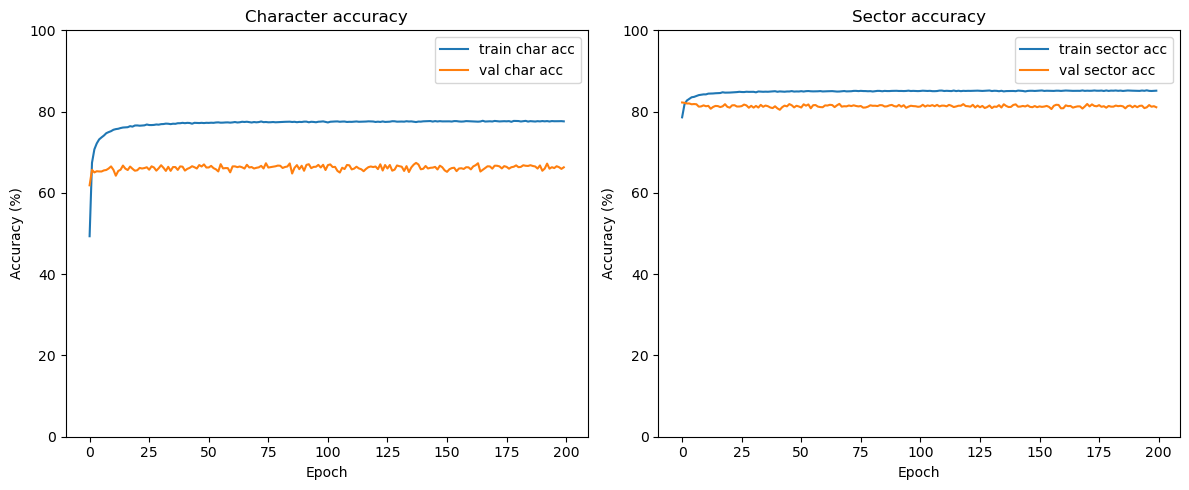

Test character accuracy: 68.93%
Test sector accuracy: 81.42%


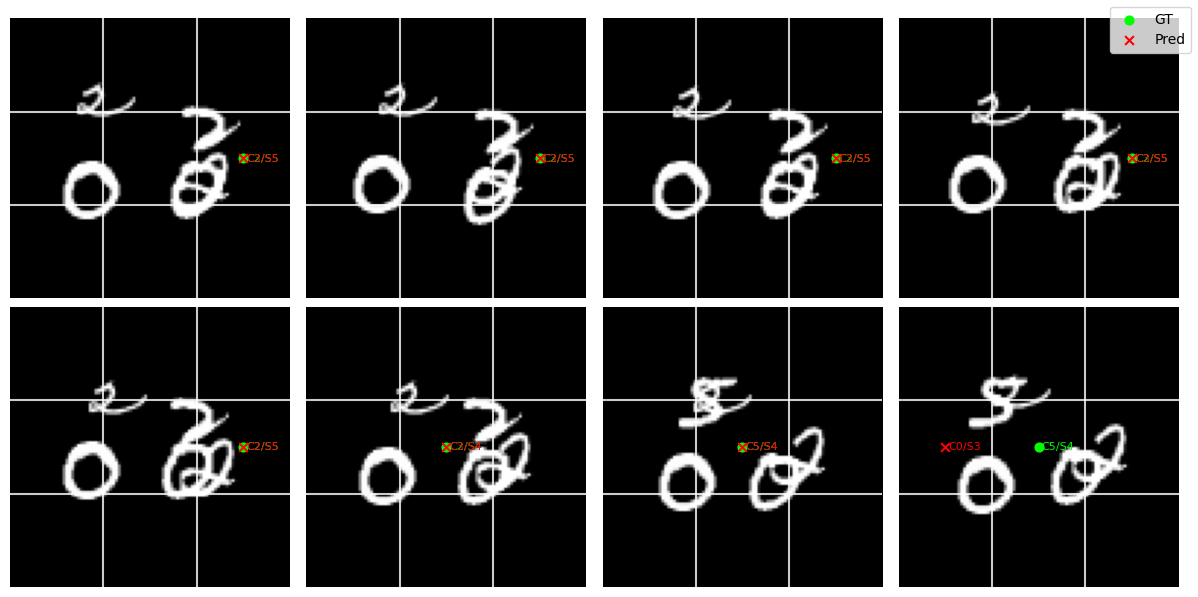


加载的结果统计:
Results keys: ['train_acc_char', 'val_acc_char', 'train_acc_pos', 'val_acc_pos', 'actual_epochs']
实际训练的epoch数: 200
Final train char acc: 77.60%
Final val char acc: 66.30%
Final train sector acc: 85.15%
Final val sector acc: 81.08%


In [37]:
# 可视化训练结果示例
# 使用训练好的结果进行可视化（例如 results_reg_ff[0] 对应 stack_size=3 的结果）
# 从本地加载训练结果
results_path = "/G/MIMOlab/Codes/aim3_RNN/results_ffn_sector_acc.pkl"
results_ff, model_ff = load_and_visualize_model_ff(results_path, num_vis=8, use_sector=True, show_test_results=True)



## One background character

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_1bg_ff = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2, kernel_size=5)
    results_1bg_ff.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20))

Training with stack size: 3
Epoch 1/20, Train Accuracy: 46.82%, Train Position Error: 201.13 pix^2
Validation: Digit accuracy - 37.67%, Position error - 281.28 pix^2
Epoch 2/20, Train Accuracy: 73.05%, Train Position Error: 149.63 pix^2
Validation: Digit accuracy - 37.82%, Position error - 278.33 pix^2
Epoch 3/20, Train Accuracy: 79.26%, Train Position Error: 130.65 pix^2
Validation: Digit accuracy - 40.99%, Position error - 287.42 pix^2
Epoch 4/20, Train Accuracy: 82.56%, Train Position Error: 118.70 pix^2
Validation: Digit accuracy - 38.55%, Position error - 299.18 pix^2
Epoch 5/20, Train Accuracy: 84.67%, Train Position Error: 110.18 pix^2
Validation: Digit accuracy - 41.65%, Position error - 276.86 pix^2
Epoch 6/20, Train Accuracy: 86.23%, Train Position Error: 102.69 pix^2
Validation: Digit accuracy - 40.19%, Position error - 285.65 pix^2
Epoch 7/20, Train Accuracy: 87.49%, Train Position Error: 96.46 pix^2
Validation: Digit accuracy - 40.45%, Position error - 265.57 pix^2
Epoch 8

KeyboardInterrupt: 

## Foreground and background character have same slow speed (1 pix)

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_1bg1s_ff = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2, kernel_size=5)
    results_1bg1s_ff.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20))

Training with stack size: 3


KeyboardInterrupt: 

## Foreground and background character have same slow speed (1 pix), only training on one factor at a time

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_1bg1s_ff_pos = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2)
    results_1bg1s_ff_pos.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20, loss_weights=[0, 0.01]))

Training with stack size: 3
Epoch 1/20, Train Accuracy: 9.81%, Train Position Error: 204.46 pix^2
Validation: Digit accuracy - 10.47%, Position error - 97.88 pix^2
Epoch 2/20, Train Accuracy: 9.82%, Train Position Error: 165.50 pix^2
Validation: Digit accuracy - 11.11%, Position error - 88.79 pix^2
Epoch 3/20, Train Accuracy: 9.80%, Train Position Error: 152.97 pix^2
Validation: Digit accuracy - 10.62%, Position error - 96.53 pix^2
Epoch 4/20, Train Accuracy: 9.82%, Train Position Error: 144.46 pix^2
Validation: Digit accuracy - 10.25%, Position error - 88.93 pix^2
Epoch 5/20, Train Accuracy: 9.85%, Train Position Error: 137.08 pix^2
Validation: Digit accuracy - 10.86%, Position error - 90.99 pix^2
Epoch 6/20, Train Accuracy: 9.84%, Train Position Error: 131.82 pix^2
Validation: Digit accuracy - 10.35%, Position error - 93.88 pix^2
Epoch 7/20, Train Accuracy: 9.81%, Train Position Error: 126.58 pix^2
Validation: Digit accuracy - 10.47%, Position error - 87.48 pix^2
Epoch 8/20, Train Ac

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg1s-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_1bg1s_ff_char = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2)
    results_1bg1s_ff_char.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20, loss_weights=[1.0, 0.0]))

Training with stack size: 3
Epoch 1/20, Train Accuracy: 64.64%, Train Position Error: 5357.91 pix^2
Validation: Digit accuracy - 62.65%, Position error - 2643.72 pix^2
Epoch 2/20, Train Accuracy: 86.10%, Train Position Error: 5357.12 pix^2
Validation: Digit accuracy - 63.23%, Position error - 2703.94 pix^2
Epoch 3/20, Train Accuracy: 90.98%, Train Position Error: 5356.95 pix^2
Validation: Digit accuracy - 61.69%, Position error - 2684.29 pix^2


KeyboardInterrupt: 

## Vary foreground and background character speeds

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_1bg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [1, 2, 4, 8, 16]
results_1bg_ff = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_FF_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_FF_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = FeedForwardConv(input_channels=ss, num_classes=10, num_pos=2)
    results_1bg_ff.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=50))

Training with stack size: 1
Epoch 1/50, Train Accuracy: 48.61%, Train Position Error: 421.72 pix^2
Validation: Digit accuracy - 45.56%, Position error - 222.14 pix^2
Epoch 2/50, Train Accuracy: 69.35%, Train Position Error: 350.92 pix^2
Validation: Digit accuracy - 47.63%, Position error - 236.55 pix^2
Epoch 3/50, Train Accuracy: 80.67%, Train Position Error: 264.08 pix^2
Validation: Digit accuracy - 47.00%, Position error - 264.74 pix^2
Epoch 4/50, Train Accuracy: 87.21%, Train Position Error: 196.05 pix^2
Validation: Digit accuracy - 48.54%, Position error - 264.82 pix^2
Epoch 5/50, Train Accuracy: 90.86%, Train Position Error: 154.25 pix^2
Validation: Digit accuracy - 46.53%, Position error - 274.98 pix^2
Epoch 6/50, Train Accuracy: 93.17%, Train Position Error: 128.55 pix^2
Validation: Digit accuracy - 47.51%, Position error - 266.84 pix^2
Epoch 7/50, Train Accuracy: 94.51%, Train Position Error: 111.60 pix^2
Validation: Digit accuracy - 46.00%, Position error - 272.08 pix^2
Epoch 

KeyboardInterrupt: 

In [ ]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of RNN models
class MC_RNN_Dataset(Dataset):
    def __init__(self, data, labels, frame_num=3):
        """
        Args:
            data (np.ndarray): Array of shape (num_samples, num_frames, height, width)
            labels (np.ndarray): Array of shape (num_samples,) with labels
            frame_num (int): Number of frames to stack for input as multichannel image
        """

        self.data = data
        self.labels = labels[['fg_char_id', 'fg_char_x', 'fg_char_y']].values
        self.frame_num = frame_num

    def __len__(self):
        return self.data.shape[0] - self.frame_num + 1

    def __getitem__(self, idx):
        # Stack frames to create a multichannel image
        stacked_frames = self.data[idx:(idx + self.frame_num)].astype(np.float32)
        # insert channel dimension
        stacked_frames = np.expand_dims(stacked_frames, axis=1)
        labels = self.labels[idx:(idx + self.frame_num)]
        return stacked_frames, labels


In [ ]:
# Create dataset class for loading stacks of frames as multichannel images
# for use in testing the performance of recurrent models
class RNNConv(nn.Module):
    def __init__(self, num_classes, num_pos, mnist_pre=None, kernel_size=3, device='cuda'):
        super(RNNConv, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding='same')
        if mnist_pre is not None:
            # set weights of self.conv1 to mnist_pre.conv1
            self.conv1.weight.data = torch.cat([torch.zeros(mnist_pre.conv1.weight.shape).to(self.device), 
                                                  torch.zeros(mnist_pre.conv1.weight.shape).to(self.device),
                                                  mnist_pre.conv1.weight], dim=1)
            self.conv1.bias.data = mnist_pre.conv1.bias.data
        self.MP1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.LNorm1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        if mnist_pre is not None:
            # set weights of self.conv2 to mnist_pre.conv2
            self.conv2.weight.data = mnist_pre.conv2.weight
            self.conv2.bias.data = mnist_pre.conv2.bias.data
        self.MP2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.LNorm2 = nn.LayerNorm([64, 12, 12])
        self.rnn = nn.RNN(input_size=64 * 12 * 12, hidden_size=512, num_layers=1, batch_first=True)
        self.LNormRNN = nn.LayerNorm(512)
        self.dropout = nn.Dropout(0.5)
        self.fcchar = nn.Linear(512, num_classes)
        self.fcpos = nn.Linear(512, num_pos)
        self.to(self.device)

    def encoder(self, x):
        return nn.Sequential(
            self.conv1,
            self.MP1,
            self.BNorm1,
            nn.ReLU(),
            self.conv2,
            self.MP2,
            self.BNorm2,
            nn.ReLU()
        )(x)

    def middle(self, x):
        return nn.Sequential(
            self.rnn,
            self.LNormRNN,
            nn.ReLU(),
            self.dropout
        )(x)

    def classifier(self, x):
        return self.fcchar(x), self.fcpos(x)

    def forward(self, x):
        x = x.to(self.device)
        x = self.encoder()(x)
        
        x = x.view(x.size(0), -1)
        x = self.middle()(x)

        char_out, pos_out = self.classifier()(x)
        return char_out, pos_out

In [ ]:
stim_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.npy"
label_train_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-train.tsv"
stims_train = np.load(stim_train_path, allow_pickle=True)
lbls_train = pd.read_csv(label_train_path, sep="\t", index_col=0)

stim_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.npy"
label_val_path = "/G/MIMOlab/Codes/aim3_RNN/stimuli/stimulus_reg-validation.tsv"
stims_val = np.load(stim_val_path, allow_pickle=True)
lbls_val = pd.read_csv(label_val_path, sep="\t", index_col=0)


stack_sizes = [3, 4, 8, 16]
results_reg_ff = []
for ss in stack_sizes:
    print(f"Training with stack size: {ss}")
    train_ds = MC_RNN_Dataset(stims_train, lbls_train, stack_size=ss)
    val_ds = MC_RNN_Dataset(stims_val, lbls_val, stack_size=ss)
    mdl_ff = RNNConv(input_channels=ss, num_classes=10, num_pos=2, kernel_size=5)
    results_reg_ff.append(network_train(mdl_ff, train_ds, val_ds, num_epochs=20))